In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o")

In [72]:
class State(TypedDict):

    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str

In [73]:
def get_summary(state: State):
    response = llm.invoke(
        f"Write a 3-sentence summary of this document {state['document']}"
    )
    return {"summary": response.content}


def get_sentiment(state: State):
    response = llm.invoke(
        f"Analysis the sentiment and tone of this document {state['document']}"
    )
    return {"sentiment": response.content}


def get_key_points(state: State):
    response = llm.invoke(
        f"List the 5 most important points of this document {state['document']}"
    )
    return {"key_points": response.content}


def get_recommendation(state: State):
    response = llm.invoke(
        f"Based on the document, list 3 recommended next steps {state['document']}"
    )
    return {"recommendation": response.content}


def get_final_analysis(state: State):
    response = llm.invoke(
        f"""
                          Give me an anlysis of the following report
                          
                          DOCUMENT ANALYSIS REPORT
                          ========================
                          
                          EXECUTIVE SUMMARY:
                          {state['summary']}
                          
                          SENTIMENT ANALYSIS:
                          {state['sentiment']}
                          
                          KEY POINTS:
                          {state['key_points']}
                          
                          RECOMMENDATIONS:
                          {state['recommendation']}
                          """
    )
    return {"final_analysis": response.content}

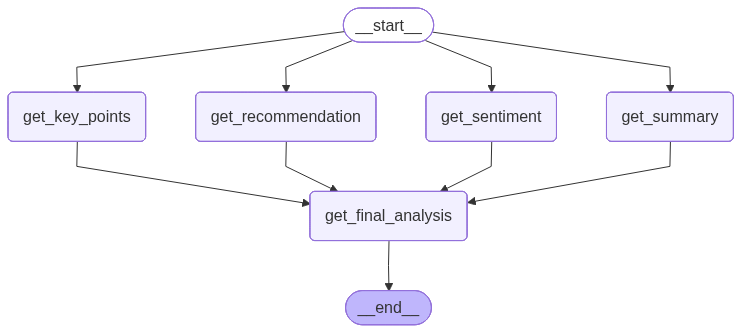

In [74]:
graph_builder = StateGraph(State)

graph_builder.add_node("get_summary", get_summary)
graph_builder.add_node("get_sentiment", get_sentiment)
graph_builder.add_node("get_key_points", get_key_points)
graph_builder.add_node("get_recommendation", get_recommendation)
graph_builder.add_node("get_final_analysis", get_final_analysis)

graph_builder.add_edge(START, "get_summary")
graph_builder.add_edge(START, "get_sentiment")
graph_builder.add_edge(START, "get_key_points")
graph_builder.add_edge(START, "get_recommendation")

graph_builder.add_edge("get_summary", "get_final_analysis")
graph_builder.add_edge("get_sentiment", "get_final_analysis")
graph_builder.add_edge("get_key_points", "get_final_analysis")
graph_builder.add_edge("get_recommendation", "get_final_analysis")
graph_builder.add_edge("get_final_analysis", END)

graph = graph_builder.compile()

graph

In [75]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream({"document": document}, stream_mode="updates"):
    print(chunk, "\n")

{'get_summary': {'summary': 'The Federal Open Market Committee has decided to lower the interest rate by a quarter percentage point and continue reducing securities holdings due to an uptick in unemployment rates, slowed job gains, and elevated inflationary pressures. Economic growth has moderated, with GDP rising at about 1.5% in the first half of the year, reflecting a slowdown in consumer spending, although business investment has picked up. While inflation remains somewhat elevated, disinflation in services continues, and the committee remains focused on its dual mandate of achieving maximum employment and stable prices, responding to changes as necessary based on economic conditions and data.'}} 

{'get_key_points': {'key_points': 'Here are the five most important points from the document:\n\n1. **Monetary Policy Adjustment:** The Federal Open Market Committee decided to lower the interest rate by a quarter of a percentage point and will continue reducing securities holdings to su